In [1]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools


from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Animal
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 300
    lr_initial = 0.1
    momentum = 0.9
    lr_epoch_step = 50
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
dataset = Animal(root_dir='/scratch1/chofer/jmlr2018_data/')
dataset.data_transforms = [
                           lambda x: {k: x[k] for k in used_directions}, 
                           numpy_to_torch_cascade,
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch._TensorBase), 
                                                        lambda x: coordinate_transform(x))
                           ]

Found data!


In [2]:
class PHTCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y                       
    
collate_fn = PHTCollate(train_env.nu, cuda=True)

In [3]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=0.1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class Mpeg7_model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 100
        
        self.reccurent_in_dim = self.n_elements #int(self.n_elements/2)
        self.reccurent_out_dim = self.n_elements #int(self.n_elements/2)
        self.batch_size = train_env.batch_size
        
        self.slayers = ModuleDict()
#         self.slayers_2_recurrent_linears = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = s            
#             l = nn.Linear(s.n_elements, self.reccurent_in_dim)
#             self.slayers_2_recurrent_linears[k] = LinearCell(self.n_elements, self.reccurent_in_dim)
            
        self.recurrent = nn.LSTM(self.reccurent_in_dim, self.reccurent_out_dim)
        
        n_1 =int(self.n_elements/2)
        self.cls = nn.Sequential(
                                 nn.BatchNorm1d(self.n_elements),
#                                  nn.ReLU(),
                                 nn.Dropout(0.2),                                 
#                                  LinearCell(self.n_elements, n_1),
#                                  nn.Dropout(0.1),
#                                  LinearCell(n_1, int(n_1/2)),
#                                  nn.Dropout(0.1),
#                                  nn.Linear(int(n_1/2), 70)
                                nn.Linear(self.n_elements, 20)
                                )
        
    def forward(self, input):
        x = []
        for k in used_directions:            
            xx = self.slayers[k](input[k])
            x.append(xx)

        x = torch.stack(x, dim=0)  
        x = torch.cat([x]*10, dim=0)
        
        x, _ = self.recurrent(x)
        
        x = x[-1]
        x = x.squeeze()
        
        x = self.cls(x)        
               
        return x
    
    def parameters_split(self):
        return {'non_linear': self.slayers.parameters(),
                'linear': itertools.chain(self.cls.parameters(), self.recurrent.parameters())}
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k].centers.data = v
            
            

In [4]:
stats_of_runs = []
def experiment():    
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.labels, y=dataset.labels))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = Mpeg7_model()
        model.center_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            train_sampler = [i for i in train_i]
            random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=collate_fn,
                              sampler=train_sampler)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=test_i)

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.75)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['dim_0_dir_0'].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            
        stats_of_runs.append(stats)
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
#     return stats_of_runs

experiment()
# stats_of_runs = experiment()


Run 0
Epoch 300/300, Batch 18/18                           
acc. 0.6815

Run 1
Epoch 300/300, Batch 18/18       
acc. 0.585

Run 2
Epoch 300/300, Batch 18/18                     
acc. 0.7395

Run 3
Epoch 300/300, Batch 18/18              
acc. 0.7375

Run 4
Epoch 300/300, Batch 18/18              
acc. 0.7005

Run 5
Epoch 300/300, Batch 18/18              
acc. 0.757

Run 6
Epoch 300/300, Batch 18/18       
acc. 0.715

Run 7
Epoch 300/300, Batch 18/18       
acc. 0.728

Run 8
Epoch 300/300, Batch 18/18       
acc. 0.7355

Run 9
Epoch 300/300, Batch 18/18       
acc. 0.7145


In [9]:
print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
[np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]

0.7094


[0.68149999999999999,
 0.58499999999999996,
 0.73950000000000005,
 0.73750000000000004,
 0.70050000000000001,
 0.75700000000000001,
 0.71499999999999997,
 0.72799999999999987,
 0.73550000000000004,
 0.71449999999999991]

<IPython.core.display.Javascript object>


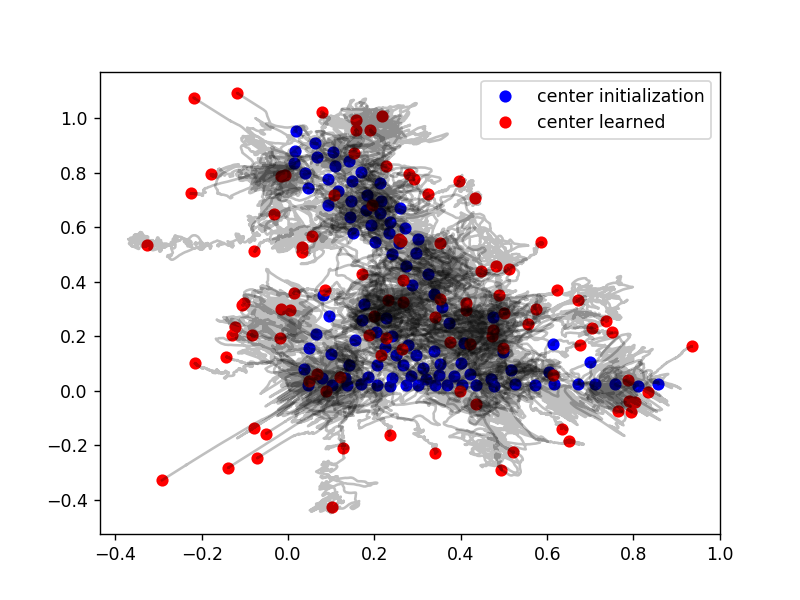

<IPython.core.display.Javascript object>


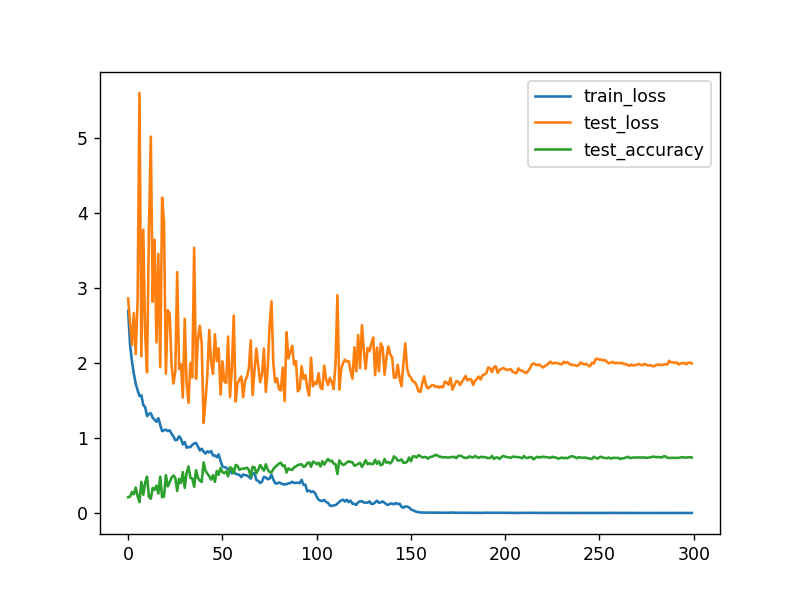

In [11]:

stats = stats_of_runs[2]
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()


In [7]:
stats['test_accuracy'][90:150]

[0.455,
 0.605,
 0.52,
 0.485,
 0.515,
 0.585,
 0.595,
 0.595,
 0.58,
 0.575,
 0.605,
 0.605,
 0.605,
 0.59,
 0.57,
 0.61,
 0.605,
 0.59,
 0.6,
 0.66,
 0.62,
 0.615,
 0.625,
 0.62,
 0.63,
 0.62,
 0.62,
 0.54,
 0.63,
 0.555,
 0.555,
 0.595,
 0.6,
 0.615,
 0.565,
 0.595,
 0.59,
 0.545,
 0.605,
 0.605,
 0.63,
 0.605,
 0.62,
 0.6,
 0.64,
 0.585,
 0.615,
 0.62,
 0.595,
 0.66,
 0.6,
 0.635,
 0.61,
 0.58,
 0.63,
 0.61,
 0.595,
 0.605,
 0.61,
 0.655]

In [8]:
model.slayers['dim_0_dir_0'].radius.min()

NameError: name 'model' is not defined